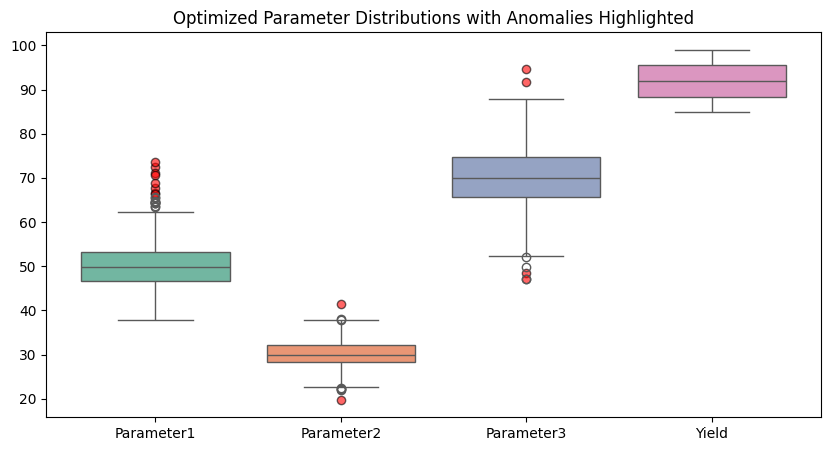

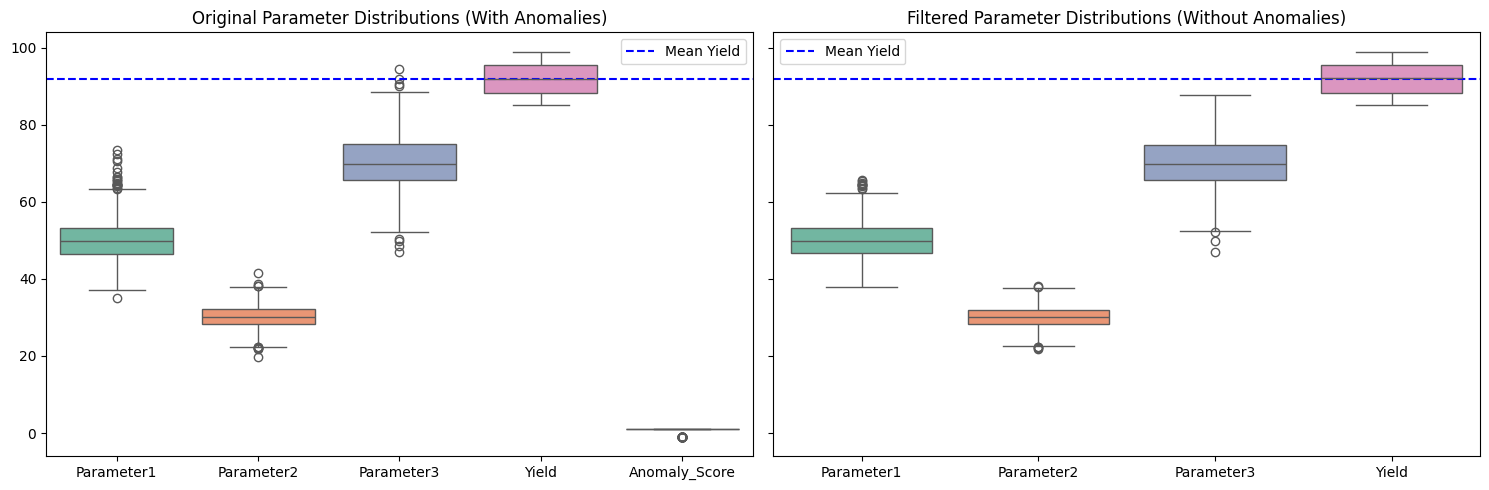

Original Control Limits:
{'Parameter1': {'LCL': np.float64(34.00359910457683), 'UCL': np.float64(66.32960174153081)}, 'Parameter2': {'LCL': np.float64(21.388786990876483), 'UCL': np.float64(38.79108629285751)}, 'Parameter3': {'LCL': np.float64(48.83614220983652), 'UCL': np.float64(91.53089541521376)}}
Refined Control Limits (Based on Non-Anomalous Data):
{'Parameter1': {'LCL': np.float64(37.03738868166724), 'UCL': np.float64(62.8215227316947)}, 'Parameter2': {'LCL': np.float64(22.50447534852858), 'UCL': np.float64(37.769278953027616)}, 'Parameter3': {'LCL': np.float64(52.18388407855903), 'UCL': np.float64(88.40628307995715)}}


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy.stats import iqr

# Generate example FDC data
data = pd.DataFrame({
    'Parameter1': np.random.normal(50, 5, 1000),
    'Parameter2': np.random.normal(30, 3, 1000),
    'Parameter3': np.random.normal(70, 7, 1000),
    'Yield': np.random.uniform(85, 99, 1000)
})

# Introduce anomalies
data.loc[np.random.choice(data.index, 20), 'Parameter1'] *= 1.3  # Outliers

# Step 1: Compute Natural Boundaries (Mean ± 3σ) for each tunable parameter
control_limits = {}
for col in data.columns[:-1]:  # Exclude Yield column
    mean, std = data[col].mean(), data[col].std()
    control_limits[col] = {'LCL': mean - 3*std, 'UCL': mean + 3*std}

# Step 2: Identify Out-of-Control Points (No Parameter_anomaly columns added)
def detect_anomalies(df, limits):
    anomalies = pd.DataFrame()
    for col, bounds in limits.items():
        anomalies = pd.concat([anomalies, df[(df[col] < bounds['LCL']) | (df[col] > bounds['UCL'])]], axis=0)
    return anomalies

# Step 3: Machine Learning-Based Anomaly Detection (Isolation Forest)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['Anomaly_Score'] = iso_forest.fit_predict(data.iloc[:, :-1])
data['ML_Anomaly'] = data['Anomaly_Score'] == -1

# Step 4: Compute Refined Control Limits (Based on Non-Anomalous Data)
filtered_data = data[~data['ML_Anomaly']]  # Correct filtering
refined_limits = {}

# Select only numeric columns for calculating refined limits
numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns[:-2]  # Exclude Yield and Anomaly columns

for col in numeric_columns:
    Q1 = np.percentile(filtered_data[col], 25)
    Q3 = np.percentile(filtered_data[col], 75)
    IQR = Q3 - Q1  # Manually calculate IQR
    refined_limits[col] = {'LCL': Q1 - 1.5 * IQR, 'UCL': Q3 + 1.5 * IQR}

# Step 5: Visualization with Anomalies Highlighted
plt.figure(figsize=(10, 5))

# Box plot for parameter distributions
sns.boxplot(data=filtered_data.iloc[:, :-2], palette="Set2")
plt.title("Optimized Parameter Distributions with Anomalies Highlighted")

# Overlay anomalies as scatter points
for i, col in enumerate(numeric_columns):
    # Dynamically calculate anomalies for the current column
    anomaly_points = data[(data[col] < control_limits[col]['LCL']) | (data[col] > control_limits[col]['UCL'])][col]
    # Scatter plot for anomalies
    plt.scatter(
        [i] * len(anomaly_points),  # Position on x-axis
        anomaly_points,            # Anomaly values
        color='red',               # Color for anomalies
        label='Anomalies' if i == 0 else "",  # Add label only once
        alpha=0.6,
        edgecolor='black'
    )

# Before-and-After Comparison of Parameter Distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Box plot for original data
sns.boxplot(data=data.iloc[:, :-1], palette="Set2", ax=axes[0])
axes[0].set_title("Original Parameter Distributions (With Anomalies)")

# Box plot for filtered data
sns.boxplot(data=filtered_data.iloc[:, :-2], palette="Set2", ax=axes[1])
axes[1].set_title("Filtered Parameter Distributions (Without Anomalies)")

# Add mean yield line to both plots
for ax in axes:
    ax.axhline(y=np.mean(filtered_data['Yield']), color='blue', linestyle='--', label='Mean Yield')
    ax.legend()

plt.tight_layout()
plt.show()

# Step 6: Optimization Insights
print("Original Control Limits:")
print(control_limits)
print("Refined Control Limits (Based on Non-Anomalous Data):")
print(refined_limits)

In [25]:
# Step 7: Compare Yield Before and After Refining Control Limits

# Yield before refining (original dataset)
yield_before = data['Yield'].mean()

# Yield after refining (filtered dataset)
yield_after = filtered_data['Yield'].mean()

# Calculate percentage improvement
yield_improvement = ((yield_after - yield_before) / yield_before) * 100

# Print results
print("\nYield Comparison:")
print(f"Average Yield Before Refining: {yield_before:.2f}")
print(f"Average Yield After Refining: {yield_after:.2f}")
print(f"Yield Improvement: {yield_improvement:.2f}%")


Yield Comparison:
Average Yield Before Refining: 91.91
Average Yield After Refining: 91.96
Yield Improvement: 0.05%


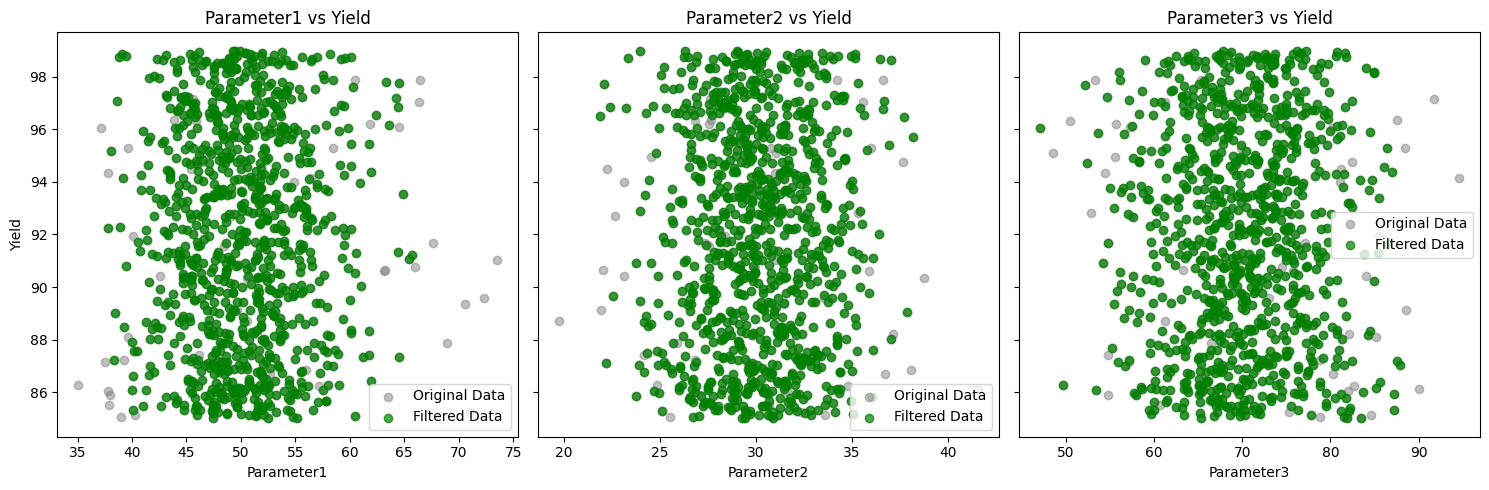

In [26]:
# Step 8: Visualize Parameter Distributions vs. Yield
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(15, 5), sharey=True)

for i, col in enumerate(numeric_columns):
    # Scatter plot of parameter values vs. yield
    axes[i].scatter(data[col], data['Yield'], alpha=0.5, label='Original Data', color='gray')
    axes[i].scatter(filtered_data[col], filtered_data['Yield'], alpha=0.7, label='Filtered Data', color='green')
    axes[i].set_title(f"{col} vs Yield")
    axes[i].set_xlabel(col)
    if i == 0:
        axes[i].set_ylabel("Yield")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have a ground truth column named 'True_Anomaly' in your dataset
if 'True_Anomaly' in data.columns:
    # Calculate evaluation metrics
    precision = precision_score(data['True_Anomaly'], data['ML_Anomaly'])
    recall = recall_score(data['True_Anomaly'], data['ML_Anomaly'])
    f1 = f1_score(data['True_Anomaly'], data['ML_Anomaly'])
    
    # Print results
    print("Anomaly Detection Evaluation (Supervised):")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion matrix
    cm = confusion_matrix(data['True_Anomaly'], data['ML_Anomaly'])
    print("\nConfusion Matrix:")
    print(cm)

In [36]:
# Compare ML anomalies with statistical control limits
for col in numeric_columns:
    ml_anomalies = data[data['ML_Anomaly']]
    outside_limits = ml_anomalies[(ml_anomalies[col] < control_limits[col]['LCL']) | 
                                  (ml_anomalies[col] > control_limits[col]['UCL'])]
    print(f"{col}: {len(outside_limits)} ML anomalies outside control limits")
    print(f"{col}: {len(ml_anomalies) - len(outside_limits)} ML anomalies inside control limits")

Parameter1: 8 ML anomalies outside control limits
Parameter1: 42 ML anomalies inside control limits
Parameter2: 2 ML anomalies outside control limits
Parameter2: 48 ML anomalies inside control limits
Parameter3: 3 ML anomalies outside control limits
Parameter3: 47 ML anomalies inside control limits


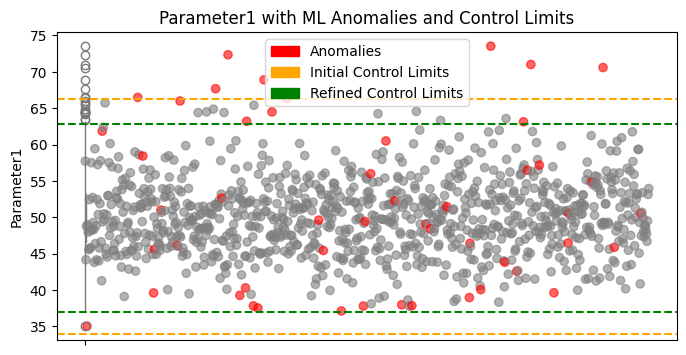

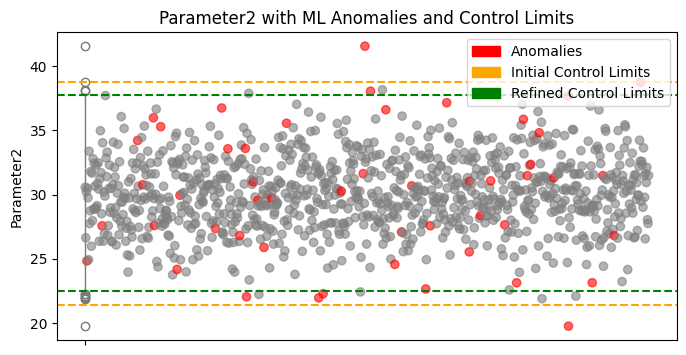

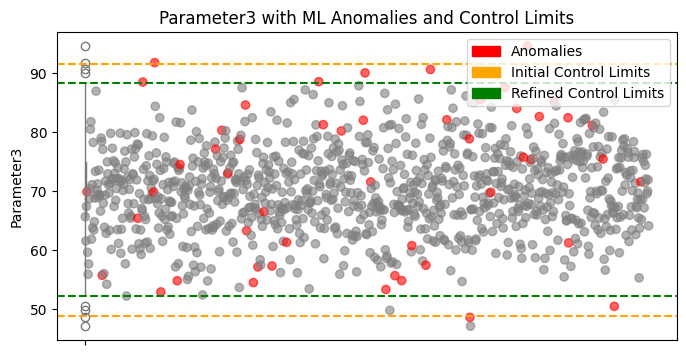

In [38]:
import matplotlib.patches as mpatches  # For creating custom legend entries

for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    
    # Box plot for the parameter
    sns.boxplot(data=data[col], color='lightblue')
    
    # Map anomalies to red and non-anomalies to gray
    anomaly_colors = data['ML_Anomaly'].map({True: 'red', False: 'gray'})
    
    # Scatter plot for parameter values with anomaly colors
    plt.scatter(data.index, data[col], c=anomaly_colors, alpha=0.6)
    
    # Plot initial control limits (mean ± 3σ)
    plt.axhline(y=control_limits[col]['LCL'], color='orange', linestyle='--', label='Initial LCL')
    plt.axhline(y=control_limits[col]['UCL'], color='orange', linestyle='--', label='Initial UCL')
    
    # Plot refined control limits (IQR-based)
    plt.axhline(y=refined_limits[col]['LCL'], color='green', linestyle='--', label='Refined LCL')
    plt.axhline(y=refined_limits[col]['UCL'], color='green', linestyle='--', label='Refined UCL')
    
    # Add title
    plt.title(f"{col} with ML Anomalies and Control Limits")
    
    # Create a custom legend for anomalies and control limits
    red_patch = mpatches.Patch(color='red', label='Anomalies')
    orange_line = mpatches.Patch(color='orange', label='Initial Control Limits')
    green_line = mpatches.Patch(color='green', label='Refined Control Limits')
    plt.legend(handles=[red_patch, orange_line, green_line])
    
    # Show the plot
    plt.show()